# Drafting and It's Affect on Downforce

#### by: Parker Johnson

We start with the 1960 Daytona 500 and a small town driver named Junior Johnson, who drove for Chevrolet. His vehicle was noticably smaller than the other cars in the race, and during test laps he was recording average speeds that were 22 mph less than his competitors. He sat down with his pit crew to figure out how to use their slower car and stay in competition.

Junior then noticed that when he was behind the other, faster cars by a very small distance, he could somehow keep speed with them. He then realized than if he could stay behind the bumper of any racerthroughout the race, and then at the very end pull ahead, he could win. He did just that, and won the 1960 Daytona 500, and is the first NASCAR driver to have been recorded using this technique called "drafting".

<center><img src="resources/junior-car.jpg"></center>

<center><img src="resources/junior-johnson-2.jpg"></center>

This idea of drafting has become incredibly integrated into today's NASCAR and Formula 1 racing. The basic consepts basically show that 2 cars travelling stacked down the track next to each other will travel faster than a single car due to the reduction in drag on each vehicle.

<center><img src="resources/diagram.gif"></center>

However, along with advantage comes disadvantage. The combination of two vehicles means that the front car will loss downforce on the rear spoiler, as the air will instead flow over the vehicle following it. If the affect occurs too quickly, the car's rear tires will spin out due to a lack of downforce. The following gif illistrates this very effectively.



<center><img src="resources/drafting issue.gif"></center>

In order to show this effect, I will simplify the geometry of a vehicle greatly, and show how much downforce and drag is generated by this vehicle. Then, I will insert a second vehicle directly behind it and analyze how the streamlines, downforce, and drag are affected.

Let's get started!

## Vehicle and Rear Wing Geometry

Obviously, a car's fluid geometry is very complex and intricate, and too complicated to model. To simplify things, I focused on modifying previous airfoils that we have worked with, as it is very similar to the shape of the vehicle. 

First, we have to import our helpful libraries and then load the geometries.

In [1]:
#import libraries
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as py
import math

%matplotlib inline

In [2]:
body_filepath = os.path.join('resources', 'Vehicle_Data.csv')
with open(body_filepath, 'r') as infile:
    x_body, y_body = np.loadtxt(infile, dtype=float, unpack=True, delimiter = ',')
    
wing_filepath = os.path.join('resources', 'Wing_Data.csv')
with open(wing_filepath, 'r') as infile:
    x_wing, y_wing = np.loadtxt(infile, dtype=float, unpack=True, delimiter = ',')

#this section creates our new geometry that relates file data to the new geometry
x_body_1 = x_body
y_body_1 = y_body * 2.0

x_wing_1 = ((x_wing - 1.03) * np.cos(np.radians(20)) - (y_wing + 0.054) * np.sin(np.radians(20)) + 1.03) - 0.03
y_wing_1 = ((y_wing + 0.054) * np.cos(np.radians(20)) + (x_wing - 1.03) * np.sin(np.radians(20)) - 0.054) + 0.07

for i in range(len(y_body)):
    if y_body_1[i] < 0:
        y_body_1[i] = y_body_1[i] * 0.25
    else:
        y_body_1[i] = y_body_1[i]
        
x_body_2 = x_body + 1.2
y_body_2 = y_body * 2.0

x_wing_2 = ((x_wing - 1.03) * np.cos(np.radians(20)) - (y_wing + 0.054) * np.sin(np.radians(20)) + 1.03) + 1.17
y_wing_2 = ((y_wing + 0.054) * np.cos(np.radians(20)) + (x_wing - 1.03) * np.sin(np.radians(20)) - 0.054) + 0.07


for i in range(len(y_body)):
    if y_body_2[i] < 0:
        y_body_2[i] = y_body_2[i] * 0.25
    else:
        y_body_2[i] = y_body_2[i]
        

Now, we must define the panels that we're using to visualize what we're working with. We do this by creating a class titled Panels.

The data included in this project must be altered so that it looks more like a vehicle with a rear wing.

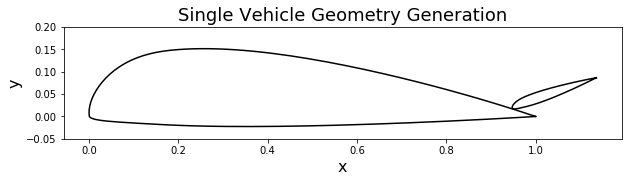

In [3]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya #panel starting point
        self.xb, self.yb = xb, yb #panel ending point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2 #panel center
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2) #panel length
        
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
            
        #panel location
        if self.beta <= np.pi:
            self.loc = 'upper' #upper surface
        else:
            self.loc = 'lower' #lower surface
            
        self.sigma = 0.0 #source strength
        self.vt = 0.0 #tangential velocity
        self.cp = 0.0 #pressure coefficient
    
def define_panels(x, y, N):
    
    panels = []
    for i in range(N):
        panels.append(Panel(x[i], y[i], x[i + 1], y[i + 1]))
    return panels

#discretize geometry into panels
panels_body_1 = define_panels(x_body_1, y_body_1, N = len(x_body) - 1)
panels_wing_1 = define_panels(x_wing_1, y_wing_1, N = len(x_wing) - 1)

panels_body_2 = define_panels(x_body_2, y_body_2, N = len(x_body) - 1)
panels_wing_2 = define_panels(x_wing_2, y_wing_2, N = len(x_body) - 1)

#plot discretized geometry for a check
width = 10
py.figure(figsize=(width, width))
py.plot(np.append([panel.xa for panel in panels_body_1], panels_body_1[0].xa),
        np.append([panel.ya for panel in panels_body_1], panels_body_1[0].ya),
        color = 'k')
py.plot(np.append([panel.xa for panel in panels_wing_1], panels_wing_1[0].xa),
        np.append([panel.ya for panel in panels_wing_1], panels_wing_1[0].ya),
        color = 'k')
py.axis('scaled', adjustable='box')
py.title('Single Vehicle Geometry Generation', fontsize=18)
py.xlabel('x',fontsize=16)
py.ylabel('y',fontsize=16)
py.ylim(-0.05, 0.2);

Now, to compare this situation to the double vehicle situation, we have to create our second vehicle, which we did in the previous cell, and place behind the current vehicle, which we can visualize in the cell below.

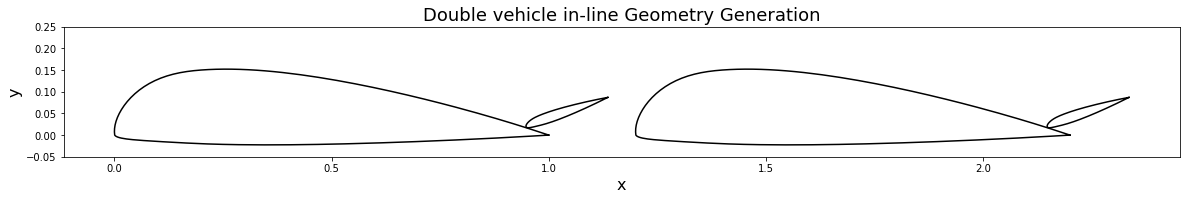

In [4]:
width = 20
py.figure(figsize=(width, width))
py.plot(np.append([panel.xa for panel in panels_body_1], panels_body_1[0].xa),
        np.append([panel.ya for panel in panels_body_1], panels_body_1[0].ya),
        color = 'k')
py.plot(np.append([panel.xa for panel in panels_wing_1], panels_wing_1[0].xa),
        np.append([panel.ya for panel in panels_wing_1], panels_wing_1[0].ya),
        color = 'k')
py.plot(np.append([panel.xa for panel in panels_body_2], panels_body_2[0].xa),
        np.append([panel.ya for panel in panels_body_2], panels_body_2[0].ya),
        color = 'k')
py.plot(np.append([panel.xa for panel in panels_wing_2], panels_wing_2[0].xa),
        np.append([panel.ya for panel in panels_wing_2], panels_wing_2[0].ya),
        color = 'k')
py.axis('scaled', adjustable='box')
py.title('Double vehicle in-line Geometry Generation', fontsize = 18)
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.ylim(-0.05, 0.25);

### These following classes and functions will be utilized in both geometry situations.

In [5]:
#create freestream class
class Freestream:
    
    def __init__(self, u_inf=5.0, alpha=0.0):
        
        self.u_inf = u_inf
        self.alpha = np.radians(alpha) #degrees to radians


In [6]:
def integral(x, y, panel, dxdk, dydk):
    
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 + 
                 (y - (panel.ya + np.cos(panel.beta) * s))**2))
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [7]:
#now we create the source contribution part of the A matrix
def source_contribution_normal(panels):
    A = np.empty((len(panels), len(panels)), dtype=float)
    np.fill_diagonal(A, 0.5)
    
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc,
                                                 panel_j,
                                                 np.cos(panel_i.beta),
                                                 np.sin(panel_i.beta))
    return A

In [8]:
def vortex_contribution_normal(panels):
    
    A = np.empty((len(panels), len(panels)), dtype=float)
    np.fill_diagonal(A, 0.0)
    
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc,
                                                 panel_j,
                                                 np.sin(panel_i.beta),
                                                 -np.cos(panel_i.beta))
    return A

In [9]:
def kutta_condition(A_source, B_vortex, N):
    
    b = np.empty((2, A_source.shape[0] + 2), dtype=float)
    
    b[0, :-2] =  B_vortex[0, :] + B_vortex[-1, :]
    b[0, -2] = - np.sum(A_source[0, :N] + A_source[N - 1, :N])
    b[0, -1] = - np.sum(A_source[0, N:] + A_source[N - 1, N:])
    
    b[1, :-2] = B_vortex[N, :] + B_vortex[-1, :]
    b[1, -2] = - np.sum(A_source[N, :N] + A_source[-1, :N])
    b[1, -1] = - np.sum(A_source[N, N:] + A_source[-1, N:])
    
    return b

In [10]:
def build_singularity_matrix(A_source, B_vortex, N):

    A = np.empty((A_source.shape[0] + 2, A_source.shape[1] + 2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = np.sum(B_vortex[:, 0:N], axis=1)
    A[0:-2, -1] = np.sum(B_vortex[:, N:], axis=1)
    #kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex, N)
    return A

In [11]:
def build_freestream_rhs(panels, freestream, N):

    b = np.empty(len(panels) + 2, dtype=float)
    
    # freestream contribution on each panel
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
        
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[N - 1].beta))
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[N].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta))
    return b

In [12]:
def compute_tangential_velocity(panels_body_1, panels_wing_1, 
                                freestream, 
                                gamma_body_1, gamma_wing_1, 
                                A_source, B_vortex, N):
    
    A = np.empty((len(panels_body_1 + panels_wing_1), 
                  len(panels_body_1 + panels_wing_1) + 2), dtype = float)
    
    A[:, :-2] = B_vortex
    
    A[:, -2] = -np.sum(A_source[:, :N], axis=1)
    A[:, -1] = -np.sum(A_source[:, N:], axis=1)
    
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta
                                   for panel in panels_body_1 + panels_wing_1])
    
    strengths = np.append([panel.sigma for panel in panels_body_1 + panels_wing_1], 
                          [gamma_body_1, gamma_wing_1])

    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_body_1):
        panel.vt = tangential_velocities[i]
        
    for i, panel in enumerate(panels_wing_1):
        panel.vt = tangential_velocities[i + N]
    
    return tangential_velocities, b, A

In [13]:
def get_velocity_field(panels, gammas, freestream, X, Y, offsets):
    #computes the velocity field on a given 2D mesh.
    
    #freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * np.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * np.ones_like(X, dtype=float)
    
    #contribution from each source
    vec_integral = np.vectorize(integral)
    for panel in panels:
        
        u += panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 1.0, 0.0)
        v += panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 0.0, 1.0)
    
    #contribution from each vortex
    N = len(offsets) - 1 # number 
    for k in range(N):
        start, end = offsets[k], offsets[k + 1]
        for panel in panels[start:end]:
            u += gammas[k] / (2 * np.pi) * vec_integral(X, Y, panel, 0.0, 1.0)
            v += gammas[k] / (2 * np.pi) * vec_integral(X, Y, panel, -1.0, 0.0)
    
    return u, v
    

### Now that we have established our equations, we can utilized the functions that we've created to analyze a single vehicle system, and create a baseline for how much downforce is generated on the vehicle.

In [14]:
freestream = Freestream(u_inf=5.0, alpha = 0.0)

In [16]:
A_source_1 = source_contribution_normal(panels_body_1 + panels_wing_1)
B_vortex_1 = vortex_contribution_normal(panels_body_1 + panels_wing_1)

In [17]:
A_1 = build_singularity_matrix(A_source_1, B_vortex_1, len(panels_body_1))
b_1 = build_freestream_rhs(panels_body_1 + panels_wing_1, freestream, len(panels_wing_1))

In [20]:
strengths_1 = np.linalg.solve(A_1, b_1)

for i, panel in enumerate(panels_body_1):
    panel.sigma = strengths_1[i]
    
for i, panel in enumerate(panels_wing_1):
    panel.sigma = strengths_1[i + len(panels_body_1)]
    
gamma_body_1 = strengths_1[-2]
gamma_wing_1 = strengths_1[-1]

In [21]:
tangent_velo, b_g, A_g = compute_tangential_velocity(panels_body_1, panels_wing_1, 
                                           freestream, gamma_body_1, gamma_wing_1, 
                                           A_source_1, B_vortex_1, len(panels_body_1))

In [22]:
u_inf = 5.0
alpha = 0.0

In [23]:
rho = 1.0
p_inf = 0.0

p = p_inf + 0.5 * rho * (-tangent_velo**2 + u_inf**2)

NOTE: This coming cell may take a while to run. This is because there are many panels and many datapoints to calculate the affect that these panels have.

The higher the number of gridpoints are selected, the longer it will take to run. Don't be surprised if it takes longer than expected if theres a large amount of points wanted.

In [24]:
#define the mesh grid
nx, ny = 20, 20 # number of points in the x and y direction
x_start, x_end = -0.1, 1.2
y_start, y_end = -0.05, 0.2
X, Y = np.meshgrid(np.linspace(x_start, x_end, nx),
                   np.linspace(y_start, y_end, ny))

# use 'offsets' to keep track of first index and last index for a foil
offsets = [0, len(panels_body_1), len(panels_body_1 + panels_wing_1)]

# gather the vortex-sheet strengths for gammas

gammas = [gamma_body_1, gamma_wing_1]

#compute the velocity field on the mesh grid
u, v = get_velocity_field(panels_body_1 + panels_wing_1, gammas, freestream, X, Y, offsets)

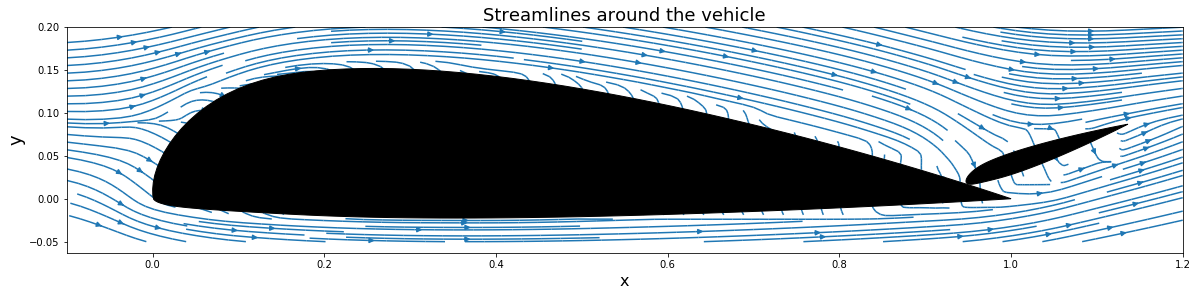

In [25]:
#plot the velocity field
width = 20
py.figure(figsize=(width, width))
py.streamplot(X, Y, u, v, density = 2)
py.fill([panel.xc for panel in panels_body_1],
        [panel.yc for panel in panels_body_1], color = 'k', zorder=2)
py.fill([panel.xc for panel in panels_wing_1],
        [panel.yc for panel in panels_wing_1], color = 'k', zorder=2)
py.axis('scaled', adjustable='box')

py.title('Streamlines around the vehicle', fontsize=18)
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=18);

Now that we know what the streamlines look like around the vehicle, we can focus on how much downforce is being applied to body the rear wing and the vehicle body itself. We can first compute the overall pressure at each panel using bernoulli's principle, and then slice the pressure array to our liking.

In [26]:
p = p_inf + 0.5 * rho * (-tangent_velo**2 + u_inf**2)

In [27]:
N = len(panels_body_1)

Fx_body_1 = -np.dot(p[:N], [np.cos(panel.beta) * panel.length for panel in panels_body_1])
Fy_body_1 = -np.dot(p[:N], [np.sin(panel.beta) * panel.length for panel in panels_body_1])

Fx_wing_1 = -np.dot(p[N:N*2], [np.cos(panel.beta) * panel.length for panel in panels_wing_1])
Fy_wing_1 = -np.dot(p[N:N*2], [np.sin(panel.beta) * panel.length for panel in panels_wing_1])

In [28]:
DF_body_1_1 = -np.sin(alpha) * Fx_body_1 + np.cos(alpha) * Fy_body_1
DF_wing_1_1 = -np.sin(alpha) * Fx_wing_1 + np.cos(alpha) * Fy_wing_1

In [29]:
print('The downforce that is generated for a sigular vehicle on the body is {0:.2f}.'.format(DF_body_1_1))

print('\nThe downforce that is generated for a sigular vehicle on the rear wing is {0:.2f}.'.format(DF_wing_1_1))

The downforce that is generated for a sigular vehicle on the body is 183.61.

The downforce that is generated for a sigular vehicle on the rear wing is -297.17.


# Two Vehicle Situation

Now, we will take our previous equations and figure out how to change them due to adding a second car into the situation, and see if the lift on the first wing is different from the singular situation.

In [ ]:
width = 20
py.figure(figsize=(width, width))
py.plot(np.append([panel.xa for panel in panels_body_1], panels_body_1[0].xa),
        np.append([panel.ya for panel in panels_body_1], panels_body_1[0].ya),
        color = 'k')
py.plot(np.append([panel.xa for panel in panels_wing_1], panels_wing_1[0].xa),
        np.append([panel.ya for panel in panels_wing_1], panels_wing_1[0].ya),
        color = 'k')
py.plot(np.append([panel.xa for panel in panels_body_2], panels_body_2[0].xa),
        np.append([panel.ya for panel in panels_body_2], panels_body_2[0].ya),
        color = 'k')
py.plot(np.append([panel.xa for panel in panels_wing_2], panels_wing_2[0].xa),
        np.append([panel.ya for panel in panels_wing_2], panels_wing_2[0].ya),
        color = 'k')
py.axis('scaled', adjustable='box')
py.title('Two Vehicle Model Situation', fontsize=18)
py.xlabel('x',fontsize=16)
py.ylabel('y',fontsize=16)
py.ylim(-0.1, 0.21);

As you can see, we have created an identical vehicle for this greater in depth analysis. This will give us the ability to see if the lift of the first vehicle is affected.

### New Formulas

Now comes the fun part. We have to change some of our formula's to allow for the insertion of two more panel bodies. Below is the first formula, the kutta condition application, which as you can see has become a lot more complicated.

In [ ]:
def kutta_condition_2(A_source, B_vortex, N):
    
    b = np.empty((4, A_source.shape[0] + 4), dtype=float)
    
    # these are the coefficients that affect the first foil
    first, last = 0, N-1 #index of the first and last panels for first foil
    b[0, :-4] =  B_vortex[first, :] + B_vortex[last,:]
    
    b[0, -4] = - np.sum(A_source[first, 0:N] + A_source[last, 0:N])
    b[0, -3] = - np.sum(A_source[first, N:2 * N] + A_source[last, N:2 * N])
    b[0, -2] = - np.sum(A_source[first, 2 * N:3 * N] + A_source[last, 2 * N:3 * N])
    b[0, -1] = - np.sum(A_source[first, 3 * N:4 * N] + A_source[last, 3 * N:4 * N])
    
    # these are the coefficients that affect the second foil
    first, last = N, 2 * N - 1 
    b[1, :-4] = B_vortex[first, :] + B_vortex[last, :]
    
    b[1, -4] = - np.sum(A_source[first, 0:N] + A_source[last, 0:N])
    b[1, -3] = - np.sum(A_source[first, N:2 * N] + A_source[last, N:2 * N])
    b[1, -2] = - np.sum(A_source[first, 2*N : 3*N] + A_source[last, 2*N:3*N])
    b[1, -1] = - np.sum(A_source[first, 3*N : 4*N] + A_source[last, 3*N:4*N])
    
    #these are the coefficients that affect the third foil
    first, last = 2*N, 3 * N - 1
    b[2, :-4] = B_vortex[2 * N, :] + B_vortex[last, :]
    
    b[2, :-4] = - np.sum(A_source[first, 0:N] + A_source[last, 0:N])
    b[2, :-3] = - np.sum(A_source[first, N:N*2] + A_source[last, N:N*2])
    b[2, :-2] = - np.sum(A_source[first, N*2:N*3] + A_source[last, N*2:N*3])
    b[2, :-1] = - np.sum(A_source[first, N*3:N*4] + A_source[last, N*3:N*4])
    
    
    #these are the coefficients that affect the fourth foil
    first, last = 3 * N - 1, -1
    b[3, :-4] = B_vortex[first, :] + B_vortex[last, :]
    
    b[3, :-4] = - np.sum(A_source[first, 0:N] + A_source[last, 0:N])
    b[3, :-3] = - np.sum(A_source[first, N:N*2] + A_source[last, N:N*2])
    b[3, :-2] = - np.sum(A_source[first, N*2:N*3] + A_source[last, N*2:N*3])
    b[3, :-1] = - np.sum(A_source[first, N*3:N*4] + A_source[last, N*3:N*4])
    
    return b

In [ ]:
def build_singularity_matrix_2(A_source, B_vortex, N):

    A = np.empty((A_source.shape[0] + 4, A_source.shape[1] + 4), dtype=float)
    # source contribution matrix
    A[:-4, :-4] = A_source
    
    # vortex contribution array
    A[:-4, -4] = np.sum(B_vortex[:, 0:N], axis=1)
    A[:-4, -3] = np.sum(B_vortex[:, N : 2 * N], axis = 1)
    A[:-4, -2] = np.sum(B_vortex[:, 2 * N:3 * N], axis = 1)
    A[:-4, -1] = np.sum(B_vortex[:, 3 * N: 4 * N], axis=1)
    
    #kutta condition array
    
    A[-4:, :] = kutta_condition_2(A_source, B_vortex, N)
    
    return A

In [ ]:
def build_freestream_rhs_2(panels, freestream, N):

    b = np.empty(len(panels) + 4, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
        
    # freestream contribution on the Kutta condition
    b[-4] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[N - 1].beta))
    
    b[-3] = -freestream.u_inf * (np.sin(freestream.alpha - panels[N].beta) +
                                 np.sin(freestream.alpha - panels[2*N - 1].beta))
    
    b[-2] = -freestream.u_inf * (np.sin(freestream.alpha - panels[2*N].beta) +
                                 np.sin(freestream.alpha - panels[3*N - 1].beta))
    
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[3*N].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta))
    return b

In [ ]:
def compute_tangential_velocity_2(panels_body_1, panels_wing_1, 
                                  panels_body_2, panels_wing_2,
                                  freestream, 
                                  gamma_body_1, gamma_wing_1, 
                                  gamma_body_2, gamma_wing_2,
                                  A_source, B_vortex, N):
    
    A = np.empty((len(panels_body_1 + panels_wing_1 + 
                      panels_body_2 + panels_wing_2), 
                  len(panels_body_1 + panels_wing_1 + 
                      panels_body_2 + panels_wing_2) + 4), dtype = float)
    
    A[:, :-4] = B_vortex
    
    A[:, -4] = -np.sum(A_source[:, :N], axis=1)
    A[:, -3] = -np.sum(A_source[:, N:N*2], axis=1)
    A[:, -2] = -np.sum(A_source[:, N*2:N*3], axis=1)
    A[:, -1] = -np.sum(A_source[:, N*3:N*4], axis=1)
    
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta
                                   for panel in panels_body_1 + panels_wing_1 + 
                                                panels_body_2 + panels_wing_2])
    
    strengths = np.append([panel.sigma for panel in panels_body_1 + panels_wing_1 +
                                                    panels_body_2 + panels_wing_2], 
                                                    [gamma_body_1, gamma_wing_1, 
                                                     gamma_body_2, gamma_wing_2])

    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_body_1):
        panel.vt = tangential_velocities[i]
        
    for i, panel in enumerate(panels_wing_1):
        panel.vt = tangential_velocities[i + N]
        
    for i, panel in enumerate(panels_body_2):
        panel.vt = tangential_velocities[i + 2 * N]
        
    for i, panel in enumerate(panels_body_2):
        panel.vt = tangential_velocities[i + 3 * N]
    
    return tangential_velocities, b, A

### Now that we've created seperate functions that will show the affects of both vehicles on the system, we can use them to model and visualize the streamlines.

In [ ]:
A_source = source_contribution_normal(panels_body_1 + panels_wing_1 + 
                                      panels_body_2 + panels_wing_2)
B_vortex = vortex_contribution_normal(panels_body_1 + panels_wing_1 + 
                                      panels_body_2 + panels_wing_2)

In [ ]:
A = build_singularity_matrix_2(A_source, B_vortex, len(panels_body_1))
b = build_freestream_rhs_2(panels_body_1 + panels_wing_1 + 
                           panels_body_2 + panels_wing_2, 
                           freestream, len(panels_wing_1))

In [ ]:
strengths = np.linalg.solve(A, b)

for i, panel in enumerate(panels_body_1):
    panel.sigma = strengths[i]
    
for i, panel in enumerate(panels_wing_1):
    panel.sigma = strengths[i + len(panels_body_1)]
    
for i, panel in enumerate(panels_body_2):
    panel.sigma = strengths[i + len(panels_body_1 + panels_wing_1)]
    
for i, panel in enumerate(panels_wing_2):
    panel.sigma = strengths[i + len(panels_body_1 + panels_wing_1 + panels_body_2)]
    
gamma_body_1 = strengths[-4]
gamma_wing_1 = strengths[-3]
gamma_body_2 = strengths[-2]
gamma_wing_2 = strengths[-1]

In [ ]:
tangent_velo_2, b_gg, A_gg = compute_tangential_velocity_2(panels_body_1, panels_wing_1,
                                               panels_body_2, panels_wing_2,
                                               freestream, 
                                               gamma_body_1, gamma_wing_1, 
                                               gamma_body_2, gamma_wing_2,
                                               A_source, B_vortex, 
                                               len(panels_body_1))

If you thought creating and plotting the streamlines for the one vehicle situation took too long, then you're going to have to step away now because this new grid meshing will take about double the time since there are double the amount of vehicle components.

In [ ]:
#define the mesh grid
nx, ny = 20, 20 # number of points in the x and y direction
x_start, x_end = -0.05, 2.5
y_start, y_end = -0.05, 0.2
X, Y = np.meshgrid(np.linspace(x_start, x_end, nx),
                   np.linspace(y_start, y_end, ny))

# use 'offsets' to keep track of first index and last index for a foil
offsets = [0, len(panels_body_1), len(panels_body_1 + panels_wing_1 + panels_body_2 + panels_wing_2)]

#again, gather the gamma strengths for each body present
gammas = [gamma_body_1, gamma_wing_1, gamma_body_2, gamma_wing_2]

#compute the velocity field on the mesh grid
u_2, v_2 = get_velocity_field(panels_body_1 + panels_wing_1 + 
                              panels_body_2 + panels_wing_2, 
                              gammas, freestream, X, Y, offsets)

In [ ]:
#plot the velocity field
width = 30
py.figure(figsize=(width, width))
py.streamplot(X, Y, u_2, v_2, density = 2)
py.fill([panel.xc for panel in panels_body_1],
        [panel.yc for panel in panels_body_1], color = 'k', zorder=2)

py.fill([panel.xc for panel in panels_wing_1],
        [panel.yc for panel in panels_wing_1], color = 'k', zorder=2)

py.fill([panel.xc for panel in panels_body_2],
        [panel.yc for panel in panels_body_2], color = 'k', zorder=2)

py.fill([panel.xc for panel in panels_wing_2],
        [panel.yc for panel in panels_wing_2], color = 'k', zorder=2)
py.axis('scaled', adjustable='box')
py.title('Streamlines around vehicles', fontsize=16)
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=18);

## Resulting Downforce

Now that the new situation has been completely modelled and visualized, we can check out what our new downforces for each vehicle component. We do this by utilizing bernoulli's equation as we did before!

In [ ]:
p = p_inf + 0.5 * rho * (-tangent_velo_2**2 + u_inf**2)

In [ ]:
N = len(panels_body_1)

#compute forces on body of vehicle 1
Fx_body_1 = -np.dot(p[:N], [np.cos(panel.beta) * panel.length for panel in panels_body_1])
Fy_body_1 = -np.dot(p[:N], [np.sin(panel.beta) * panel.length for panel in panels_body_1])

#compute forces on wing of vehicle 1
Fx_wing_1 = -np.dot(p[N : 2*N], [np.cos(panel.beta) * panel.length for panel in panels_wing_1])
Fy_wing_1 = -np.dot(p[N : 2*N], [np.sin(panel.beta) * panel.length for panel in panels_wing_1])

#compute forces on body of vehicle 2
Fx_body_2 = -np.dot(p[2*N : 3*N], [np.cos(panel.beta) * panel.length for panel in panels_body_2])
Fy_body_2 = -np.dot(p[2*N : 3*N], [np.cos(panel.beta) * panel.length for panel in panels_body_2])

#compute forces on wing of vehicle 2
Fx_wing_2 = -np.dot(p[3*N : 4*N], [np.cos(panel.beta) * panel.length for panel in panels_wing_2])
Fy_wing_2 = -np.dot(p[3*N : 4*N], [np.cos(panel.beta) * panel.length for panel in panels_wing_2])

In [ ]:
DF_body_1_2 = -np.sin(alpha) * Fx_body_1 + np.cos(alpha) * Fy_body_1
DF_wing_1_2 = -np.sin(alpha) * Fx_wing_1 + np.cos(alpha) * Fy_wing_1
DF_body_2 = -np.sin(alpha) * Fx_body_2 + np.cos(alpha) * Fy_body_2
DF_wing_2 = -np.sin(alpha) * Fx_wing_2 + np.cos(alpha) * Fy_wing_2

In [ ]:
print('The downforce on the leading vehicle body is now {0:.2f}'.format(DF_body_1_2))
print('compared to the previous single vehicle body downforce of {0:.2f}\n'.format(DF_body_1_1))

print('The downforce on the leading vehicle wing is now {0:.2f}'.format(DF_wing_1_2))
print('compared to the single vehicle wing downforce of {0:.2f}\n'.format(DF_wing_1_1))

print('The downforce on the following vehicle body is {0:.2f}'.format(DF_body_2))
print('compared to the single vehicle body downforce of {0:.2f}\n'.format(DF_body_1_1))

print('The downforce on the following vehicle wing is now {0:.2f}'.format(DF_wing_2))
print('compared to the single vehicle wing downforce of {0:.2f}'.format(DF_wing_1_1))

## Conclusions and Future Work

The comparisons of the downforce values above show that adding a second vehicle near the rear of another vehicle does not affect the downforce on any components of either vehicle. But as we see in the image at the beginning of this lesson, it still has an effect. This is due to the viscosity of the fluid, and with the source-vortex panel method we have no way of accounting for the high viscosity of air when travelling at very high speeds. In conclusion, this lesson could be taken and if a boundary layer analysis is applied to it, then you will see the boundary layer of the two vehicles combine. Once the rear vehicle moves in close enough, this will occur, and the air over the rear wing of the first vehicle will instead be sent over the rear wing of the second vehicle.